## Air-Quality-in-Durban-Part-2-Linear-Regression-with-TimeSeries-Data-from-MongoDB by Dumisani Maxwell Mukuchura

#### Dataset Source: *https://open.africa/dataset/sensorsafrica-airquality-archive-durban*

##### Contact: dumisanimukuchura@gmail.com | LinkedIn: https://www.linkedin.com/in/dumisani-maxwell-mukuchura-4859b7170/

##### This Project will explore the time series dataset for Air Quality and will predict P2.5 values using Linear Regression Model 

Kindly note this was done from a Local machine on Windows with a locally hosted database using Mongo DB, Mongo DB Compass and MongoDB Shell i.e a NoSQL database.  

In [69]:
#Import Libraries and Dependencies

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import pytz #to manipulate pythone timezones

from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.utils.validation import check_is_fitted

## 1. Prepare Data

### 1.1. Connect Database

In [8]:
#Connect Database
client = MongoClient(host="localhost", port=27017)
db = client["air_quality"]  #database
durban = db["durban"]  #collection

In [56]:
#Wrangle Function to get data

def wrangle(collection):
    #Generate Result from Collections
    result = collection.find(
        {"value_type": "P2"},
        projection = {"value": 1, "timestamp":1, "_id":0}
    )
    #Create Dataframe from result
    df = pd.DataFrame(result).set_index("timestamp")

    #Rename "Value" column to "P2 Column"
    df = df.rename(columns={"value": "P2"})

    #Localize Time to Durban, Africa
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Johannesburg")

    #Resample the Time Series Data with 1H with mean summarization to create a 1Hour frequency.
    df = df["P2"].resample("1h").mean().fillna(method="ffill").to_frame() # Converts the resulting Series (which consists of mean values) back into a DataFrame.

    #Since this will utilize a Linear Regression model, we will need a Feature and a Target, and we can create a Lag Feature to have that.
    df["P2.L1"] = df["P2"].shift(1)
    
    #Drop NaN rows
    df.dropna(inplace=True)

    return df

In [57]:
#Import Data into Dataframe
df = wrangle(durban)
df.head()

C:\Users\Dumisani Mukuchura\AppData\Local\Temp\ipykernel_22660\2376820210.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df["P2"].resample("1h").mean().fillna(method="ffill").to_frame() # Converts the resulting Series (which consists of mean values) back into a DataFrame.


,P2,P2.L1
timestamp,,
2017-11-24 17:00:00+02:00,5.000,5.000
2017-11-24 18:00:00+02:00,5.000,5.000
2017-11-24 19:00:00+02:00,12.494,5.000
2017-11-24 20:00:00+02:00,7.830,12.494
2017-11-24 21:00:00+02:00,7.600,7.830


In [43]:
#Check DF Shape
df.shape

(141, 1)

### 1.2. Explore

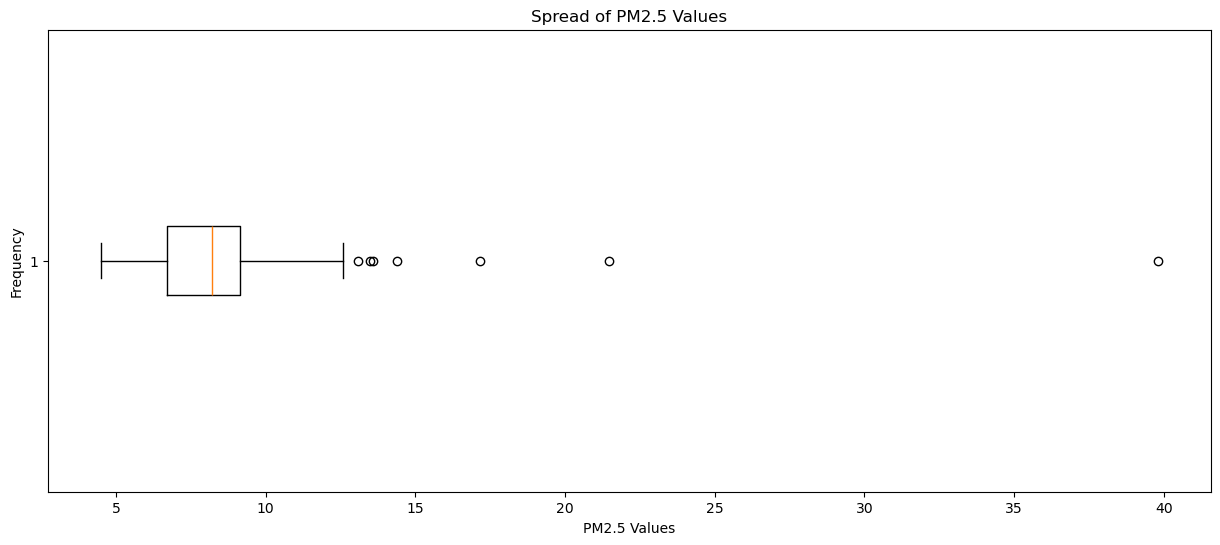

In [49]:
#View the spread of the Values of P2.5 using a Box Plot

fig, ax = plt.subplots(figsize=(15, 6))
plt.boxplot(df["P2"], vert=False)
plt.xlabel("PM2.5 Values")
plt.ylabel("Frequency")
plt.title("Spread of PM2.5 Values");

#or df["value"].plot(kind="box", vert=False, title = "Distribution of PM2.5 Readings", ax=ax);

- From the AQI scale all the values are withing the 0-500 thresholds, thus no Outliers to remove.

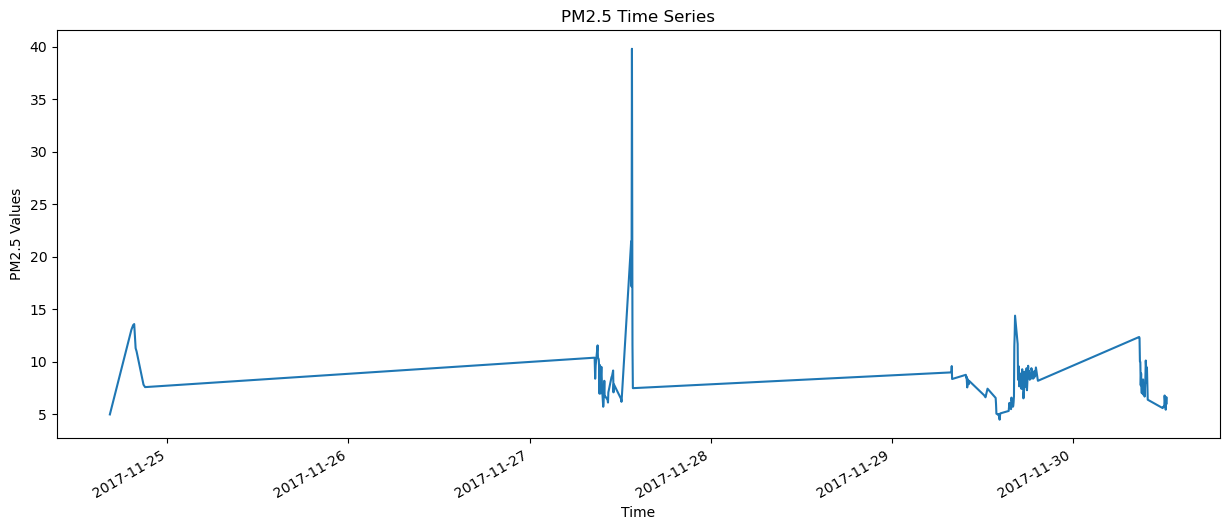

In [50]:
#Check for any Missing Values and also if there is existence of Anomarlies by a line plot

fig, ax = plt.subplots(figsize = (15, 6))
df["P2"].plot(ax=ax, xlabel = "Time", ylabel = "PM2.5 Values", title ="PM2.5 Time Series");

- We notice that there are no missing values and also the need to check the date ranges then proceed to resample to smoothen, aggreagate at the time interval we need to predict at.

In [18]:
df.index.max()

Timestamp('2017-11-30 12:28:12.113000+0200', tz='Africa/Johannesburg')

In [17]:
df.index.min()

Timestamp('2017-11-24 16:21:55.531000+0200', tz='Africa/Johannesburg')

- This data is across a One Week Span from Nov 24 2017 to Nov 30 2017. We have 168 Hours in a week and our DataFrame has 160 entries thus we can sample at every Hour and use forward fill to impute any missing values. 
- Thus we can utilize resampling to aggregate, downsample, upsample or regularize our time series dataset.

In [58]:
#Understand the correlation of P2 and P2.L1 columns

df.corr()

,P2,P2.L1
P2,1.000000,0.951952
P2.L1,0.951952,1.000000


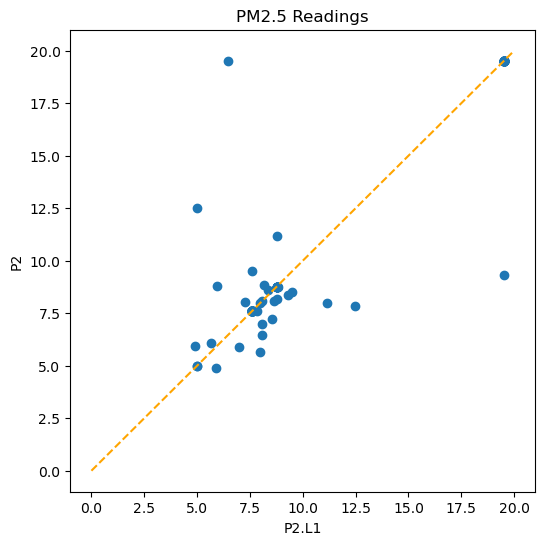

In [62]:
#Creation of a scatter plot to showcase the Correlation 

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x = df["P2.L1"], y = df["P2"])
ax.plot([0,20], [0,20], linestyle = "--", color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Readings");

## 2. Build Model

### 2.1. Split Data

- When dealing with Time Series data and Linear Regression Models we have to do 2 splits one in the Vertical that gives Features and Target and another in the Horizontal direction that gives us training and test data considering this is time we can not have future data in training set that would give leakage when testing or having past data in test dataset that would be leaked already.

#### 2.1.1. Vertical Split - Feature and Target Split

In [65]:
#Vertical Split - Note both Feature and Target must maintain their timestamp indices.
target = "P2"
y = df[target] #P2
X = df.drop(columns = target) #P2.L1

#OR 
#target = "P2"
#Feature = ["P2.L1"]
#y = df[target] #P2
#X = df[Feature] #P2.L1

print(y.head())
print(X.head())

timestamp
2017-11-24 17:00:00+02:00     5.000
2017-11-24 18:00:00+02:00     5.000
2017-11-24 19:00:00+02:00    12.494
2017-11-24 20:00:00+02:00     7.830
2017-11-24 21:00:00+02:00     7.600
Freq: h, Name: P2, dtype: float64
                            P2.L1
timestamp                        
2017-11-24 17:00:00+02:00   5.000
2017-11-24 18:00:00+02:00   5.000
2017-11-24 19:00:00+02:00   5.000
2017-11-24 20:00:00+02:00  12.494
2017-11-24 21:00:00+02:00   7.830


#### 2.1.2. Horizontal Split - Train and Test Split for Time Series data

In [66]:
#Horizontal Split with a 80/20 Train/Test split ratio
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

len(X_train) + len(X_test) == len(X)

True

### 2.2. Baseline Model

In [67]:
#Baseline Model using the mean as the predicted value 
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean PM2.5 Reading:", round(y_mean, 2))
print("Baseline Mean Absolute Error:", round(baseline_mae, 2))

Mean PM2.5 Reading: 12.1
Baseline Mean Absolute Error: 5.56


### 2.3. Iterate - Instatiate and Fit Model

In [70]:
#Instatiate and Fit the LinearRegression model
model = LinearRegression() 
model.fit(X_train, y_train)

LinearRegression()

In [71]:
#Check if Model is fitted
check_is_fitted(model)

### 2.4. Evaluate.

In [72]:
#Training Data Evaluation
training_mae = mean_absolute_error(y_train, model.predict(X_train))

#Test Data Evaluation
test_mae = mean_absolute_error(y_test, model.predict(X_test))

#Print the Mean Absolute Error
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.66
Test MAE: 0.73
